# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip

In [7]:
import torch
from utils import plot_training, precompute_features, train
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

dir_path = "data/TP4_images/"

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [8]:
base_model.fc = nn.Linear(512, 2)

In [9]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

<unknown>:21: SyntaxWarning: invalid escape sequence '\c'
<unknown>:20: SyntaxWarning: invalid escape sequence '\c'
  4%|▎         | 18/500 [00:00<00:05, 90.76it/s]

Epoch 1, train loss: 0.5933, test loss: 1.0531, accuracy: 0.5000


 24%|██▍       | 120/500 [00:01<00:03, 105.46it/s]

Epoch 101, train loss: 0.2625, test loss: 0.7086, accuracy: 0.5476


 45%|████▍     | 223/500 [00:02<00:02, 109.76it/s]

Epoch 201, train loss: 0.1333, test loss: 0.8503, accuracy: 0.5238


 62%|██████▏   | 311/500 [00:02<00:01, 101.82it/s]

Epoch 301, train loss: 0.0856, test loss: 0.9265, accuracy: 0.5476


 84%|████████▍ | 419/500 [00:04<00:00, 100.68it/s]

Epoch 401, train loss: 0.0619, test loss: 0.8852, accuracy: 0.6190


100%|██████████| 500/500 [00:04<00:00, 104.13it/s]


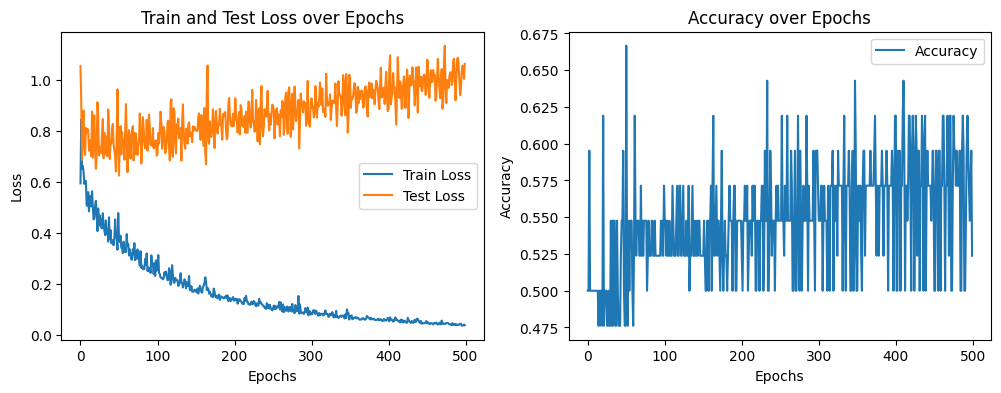

In [11]:
from copy import deepcopy

features_model = deepcopy(base_model)
features_model.fc = nn.Identity()

features_dataset = precompute_features(features_model, north_dataset, device=device)
features_dataloader = DataLoader(features_dataset, batch_size=8, shuffle=True)

test_features_dataset = precompute_features(features_model, test_dataset, device=device)
test_features_dataloader = DataLoader(
    test_features_dataset, batch_size=len(test_features_dataset)
)

last_layer = nn.Sequential(nn.Linear(512, 2))

n_epochs = 500
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=1e-3, weight_decay=1e-4)

train_loss_history, test_loss_history, accuracy_history = train(
    last_layer,
    features_dataloader,
    test_features_dataloader,
    loss_fn,
    optimizer,
    n_epochs,
    device,
)

plot_training(train_loss_history, test_loss_history, accuracy_history)

<div class="alert alert-info">  We can see that the test loss increases over time because the model gets more and more confident in its predictions, which can be checked by inspecting the logits. Nonetheless, the accuracy over the test set keeps increasing so the model is not overfitting. This can be mitigated by increasing the weight decay.

The accuracy increases until 0.62, which is not outstanding but still better than a random classifier so the model has indeed learned properly  </div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

Using cache found in /Users/matthieuneau/.cache/torch/hub/pytorch_vision_main
  4%|▍         | 19/500 [00:00<00:05, 92.08it/s]

Epoch 1, train loss: 0.6325, test loss: 1.0040, accuracy: 0.5000


 24%|██▎       | 118/500 [00:01<00:03, 108.59it/s]

Epoch 101, train loss: 0.0086, test loss: 1.0234, accuracy: 0.7143


 44%|████▎     | 218/500 [00:02<00:02, 106.93it/s]

Epoch 201, train loss: 0.0033, test loss: 1.1561, accuracy: 0.7381


 63%|██████▎   | 317/500 [00:03<00:01, 103.66it/s]

Epoch 301, train loss: 0.0015, test loss: 1.1934, accuracy: 0.7381


 84%|████████▍ | 419/500 [00:04<00:00, 109.31it/s]

Epoch 401, train loss: 0.0008, test loss: 1.2677, accuracy: 0.7381


100%|██████████| 500/500 [00:04<00:00, 104.84it/s]


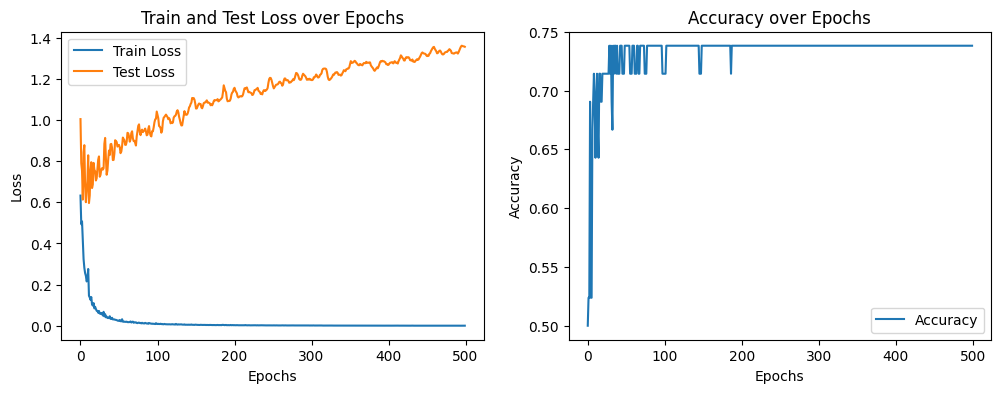

In [12]:
pretrained_model = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
pretrained_lora = deepcopy(pretrained_model)

pretrained_lora.fc = nn.Identity()

pretrained_dataset = precompute_features(pretrained_lora, north_dataset, device)
pretrained_dataloader = DataLoader(pretrained_dataset, batch_size=8, shuffle=True)

test_pretrained_dataset = precompute_features(pretrained_lora, test_dataset, device)
# The whole batch fits in memory so we might as well load it all at once
test_pretrained_dataloader = DataLoader(
    test_pretrained_dataset, batch_size=len(test_pretrained_dataset)
)

last_layer = nn.Sequential(nn.Linear(512, 2))

n_epochs = 500
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=1e-3, weight_decay=1e-4)


train_loss_history, test_loss_history, accuracy_history = train(
    last_layer,
    pretrained_dataloader,
    test_pretrained_dataloader,
    loss_fn,
    optimizer,
    n_epochs,
    device,
)

torch.save(last_layer.state_dict(), "last_layer_finetune.pth")

plot_training(train_loss_history, test_loss_history, accuracy_history)

<div class="alert alert-info">The training process leverages transfer learning thanks to the meaningful features learned by the model when trained on ImageNet during its pretraining phase. Therefore the accuracy reached is higher than previously and goes up to 0.75</div>

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

<div class="alert alert-info">
LoRA (Low-Rank Adaptation) is a fine-tuning method for large pre-trained models that avoids updating all the parameters. Instead, it freezes the original weights and injects a trainable low-rank update into specific layers. Concretely, for a weight matrix W, the adapted weight is given by

$$W^*=W+BA$$

where $B$ and $A$ are low-rank matrices. This design dramatically reduces the number of parameters to be optimized, leading to efficient adaptation with lower computational overhead while still achieving strong performance on downstream tasks.

In our case, we apply LoRA to convolutions. The idea remains the same but instead of using matrices like in linear layers we use convultion filters. The idea is to replace a single filter with many parameters with a Down Conv filter followed by an Up Conv filter where:

- Down conv is similar to the original convlutional layer but has $r << C_{out}$ channels as output
- Up conv is a $C{out} \times r \times 1 \times 1$ convolutional filter that upsamples the number of channels of the output of DownConv
</div>


![Alternative text](drawing_lora.png)

### Baseline pretrained ResNet18

In [ ]:
# resnet = deepcopy(pretrained_model)
# resnet.fc = nn.Linear(512, 2)

# train_dataloader = DataLoader(north_dataset, batch_size=8, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

# n_epochs = 20
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(resnet.parameters(), lr=5e-4, weight_decay=1e-4)

# train_loss_history, test_loss_history, accuracy_history = train(
#     resnet, train_dataloader, test_dataloader, loss_fn, optimizer, n_epochs, device
# )

# plot_training(train_loss_history, test_loss_history, accuracy_history)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: matthieu-neau to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

Epoch 1, train loss: 0.9164, test loss: 0.8075, accuracy: 0.1905


 20%|██        | 6/30 [00:03<00:14,  1.67it/s]

Epoch 6, train loss: 0.6099, test loss: 1.5402, accuracy: 0.5000


 37%|███▋      | 11/30 [00:06<00:11,  1.71it/s]

Epoch 11, train loss: 0.4334, test loss: 1.4506, accuracy: 0.5000


 53%|█████▎    | 16/30 [00:09<00:08,  1.68it/s]

Epoch 16, train loss: 0.3114, test loss: 0.8364, accuracy: 0.4524


 70%|███████   | 21/30 [00:12<00:05,  1.70it/s]

Epoch 21, train loss: 0.2124, test loss: 0.9143, accuracy: 0.5000


 87%|████████▋ | 26/30 [00:15<00:02,  1.75it/s]

Epoch 26, train loss: 0.1661, test loss: 1.0593, accuracy: 0.5000


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]

True
False


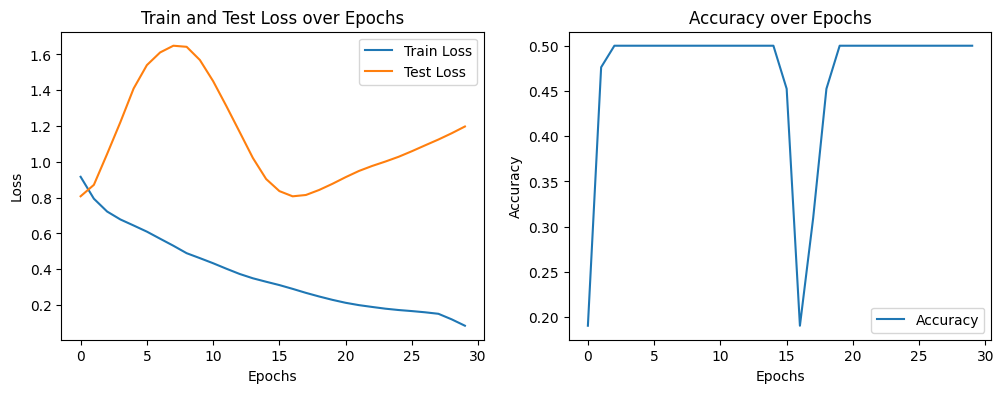

In [13]:
from lora import train_lora, build_lora_resnet

pretrained_resnet = deepcopy(pretrained_model)
pretrained_lora = deepcopy(pretrained_model)
build_lora_resnet(pretrained_lora, r=4, alpha=4)

pretrained_lora.fc = nn.Linear(512, 2)
pretrained_resnet.fc = nn.Linear(512, 2)

pretrained_resnet.eval()
for param in pretrained_resnet.parameters():
    param.requires_grad = False

train_dataloader = DataLoader(north_dataset, batch_size=42, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=42)

old_weights = pretrained_resnet.layer1[0].conv1.weight.data.clone().to(device)
old_weights2 = pretrained_lora.layer1[0].conv1.downConv.weight.data.clone().to(device)

optimizer = torch.optim.Adam(pretrained_lora.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
train_loss_history, test_loss_history, accuracy_history = train_lora(
    pretrained_model=pretrained_resnet,
    lora_model=pretrained_lora,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
)

new_weights = pretrained_resnet.layer1[0].conv1.weight.data.clone().to(device)
new_weights2 = pretrained_lora.layer1[0].conv1.downConv.weight.data.clone().to(device)

print(torch.allclose(old_weights, new_weights))
print(torch.allclose(old_weights2, new_weights2))

plot_training(train_loss_history, test_loss_history, accuracy_history)
# torch.save(lora_model.state_dict(), "lora_resnet.pth")

In [15]:
from torchinfo import summary
from lora import inflate_lora, merge_models

lora_resnet2 = deepcopy(pretrained_lora)
inflate_lora(lora_resnet2)
merge_models(pretrained_resnet, lora_resnet2, device)
summary(lora_resnet2)
assert isinstance(pretrained_resnet, models.ResNet)

## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

In [16]:
## Data Augmentation
from torchvision.transforms import v2
from torch.utils.data import default_collate
import matplotlib.pyplot as plt


augmentation_transform = v2.Compose(
    [
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(15),
        v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

augmented_dataset = datasets.ImageFolder(
    "data/TP4_images/north_dataset_sample", transform=augmentation_transform
)

cutmix = v2.CutMix(num_classes=2)
mixup = v2.MixUp(num_classes=2)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])


def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))


augmented_dataloader = DataLoader(
    augmented_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn
)

# for images, labels in augmented_dataloader:
#     print(f"before CutMix/MixUp: {images.shape = }, {labels}")
#     # images, labels = cutmix_or_mixup(images, labels)
#     print(f"after CutMix/MixUp: {images.shape = }, {labels}")
#     plt.imshow(images[0].squeeze(0).permute(1, 2, 0))
#     break

/Users/matthieuneau/Library/Caches/pypoetry/virtualenvs/practice-labs-lU_vlk8p-py3.12/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
pretrained_resnet = deepcopy(pretrained_model)
pretrained_lora = deepcopy(pretrained_model)
pretrained_resnet.fc = nn.Linear(512, 2)
pretrained_lora.fc = nn.Linear(512, 2)
build_lora_resnet(pretrained_lora, r=4, alpha=1)

optimizer = torch.optim.Adam(pretrained_lora.parameters(), lr=5e-4)
n_epochs = 20
train_loss_history, test_loss_history, accuracy_history = train_lora(
    pretrained_model=pretrained_resnet,
    lora_model=pretrained_lora,
    test_dataloader=test_dataloader,
    train_dataloader=augmented_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
)


plot_training(train_loss_history, test_loss_history, accuracy_history)

# assert isinstance(lora_model, models.ResNet)

  5%|▌         | 1/20 [00:01<00:23,  1.26s/it]

Epoch 1, train loss: 0.7523, test loss: 6.6314, accuracy: 0.5000


 30%|███       | 6/20 [00:06<00:14,  1.02s/it]

Epoch 6, train loss: 0.5569, test loss: 0.8555, accuracy: 0.5238


 55%|█████▌    | 11/20 [00:11<00:09,  1.00s/it]

Epoch 11, train loss: 0.6421, test loss: 0.9160, accuracy: 0.4762


 80%|████████  | 16/20 [00:16<00:04,  1.03s/it]

Epoch 16, train loss: 0.5971, test loss: 0.8504, accuracy: 0.5000


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


In [ ]:
torch.save(lora_model.state_dict(), "daug_resnet.pth")

## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 